## Import Dependency

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Load Dataset

In [2]:
file =  '../Dataset/insurance.csv'

In [3]:
df = pd.read_csv(file)

In [ ]:
# Sample Data
print(df.head())

# Rows and Columns Count
print ("Rows and Column")
print(df.shape)

# Get basic statistics for numerical columns
print(df.describe())

# Check column data types
print(df.dtypes)

In [ ]:
# Check for missing values
# Result: No missing data

print(df.isnull().sum())

In [ ]:
# Check for Data Consistency
# Result: Data format is correct

# List of expected categories for each column
expected_smoker_values = ['yes', 'no']
expected_sex_values = ['female', 'male']
expected_region_values = ['southwest', 'southeast', 'northwest', 'northeast']

# Check for unexpected values in the 'smoker' column
unexpected_smoker_values = df[~df['smoker'].isin(expected_smoker_values)]['smoker']
print("Unexpected values in 'smoker' column:", unexpected_smoker_values.unique())

# Check for unexpected values in the 'sex' column
unexpected_sex_values = df[~df['sex'].isin(expected_sex_values)]['sex']
print("Unexpected values in 'sex' column:", unexpected_sex_values.unique())

# Check for unexpected values in the 'region' column
unexpected_region_values = df[~df['region'].isin(expected_region_values)]['region']
print("Unexpected values in 'region' column:", unexpected_region_values.unique())


In [ ]:
# Check for Duplicate Data
# Result: One Duplicate row

print(f"Duplicate rows: {df.duplicated().sum()}")

# Display duplicates (optional, to inspect them)
duplicates = df[df.duplicated()]
print(duplicates)

In [ ]:
# Plot histograms for numerical columns
# Result: distribution of charges indicates a positive skew

numerical_cols = ['age', 'bmi', 'children', 'charges']

# Create a figure and axes for subplots
plt.figure(figsize=(14, 8))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 2, i)  # 2 rows, 2 columns
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

In [ ]:
# Check skewness for the 'charges' column
# Result: positive skew with 1.515
skewness = df['charges'].skew()
print(f"Skewness of charges: {skewness}")

In [ ]:
# Note: Distribution data for non-smokers is significantly higher than smokers
# Bar plots for categorical features
categorical_cols = ['sex', 'smoker', 'region']

plt.figure(figsize=(12, 6))

for i, col in enumerate(categorical_cols, 1):
    plt.subplot(1, 3, i)  # 1 row, 3 columns
    sns.countplot(x=df[col])
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()


In [ ]:
# Encode Categorical data to numeric

# Perform One-Hot Encoding for 'sex', 'smoker', and 'region'
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

In [ ]:
# Pairplot to analyze relationships between numerical variables
sns.pairplot(df)
plt.show()

In [ ]:
# Compute the correlation matrix (including encoded columns)
correlation_matrix = df_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()


## Data Pre Processing

## Handling Duplicate Data

In [4]:
# Remove the duplicate row
df_cleaned = df.drop_duplicates()

# Verify that the duplicate is removed
print(f"After removing duplicates, the new count of rows: {df_cleaned.shape[0]}")

After removing duplicates, the new count of rows: 1337


## Handling Skewed data

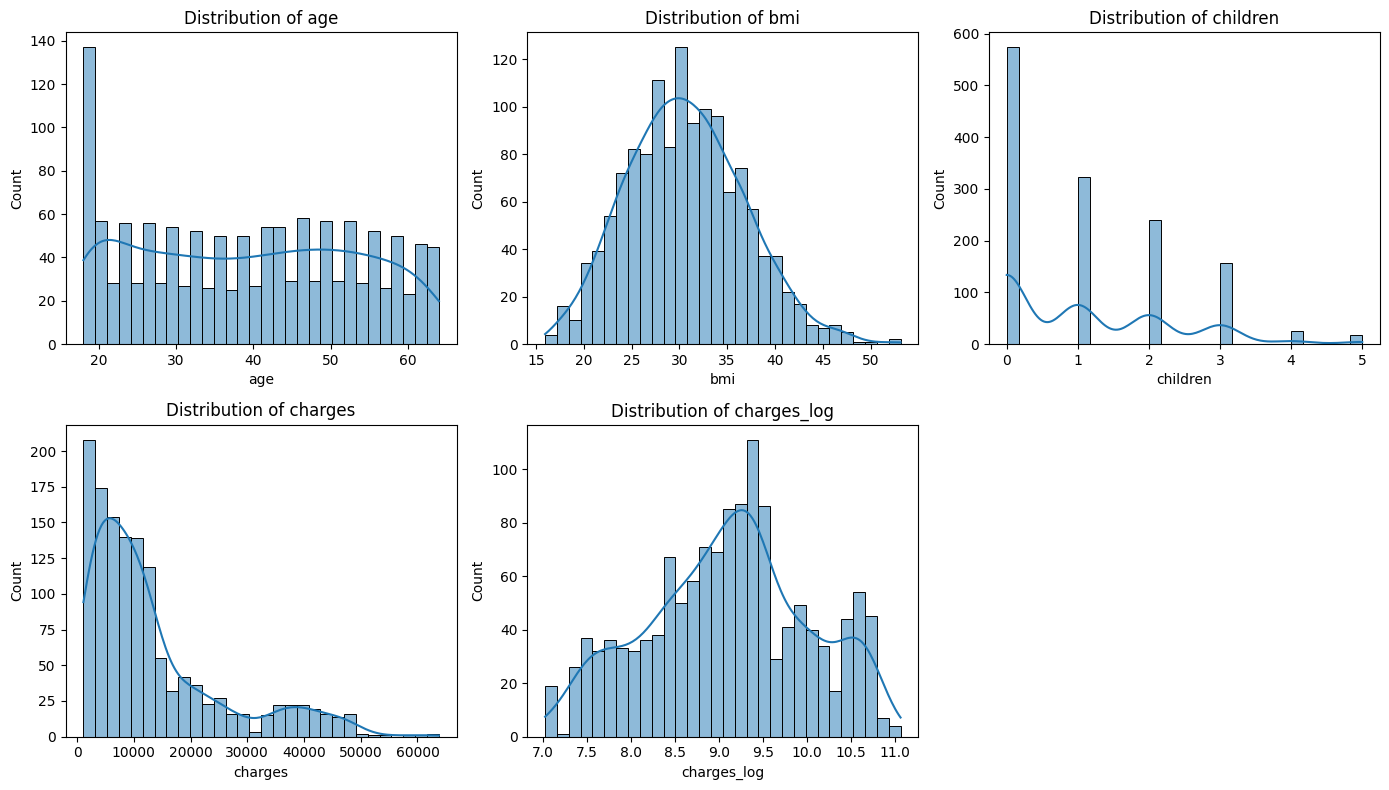

In [5]:
# Apply log transformation to 'charges' to handle the positive skew
df['charges_log'] = np.log1p(df['charges'])  # log1p is log(x + 1)

# Update numerical columns to include 'charges_log'
numerical_cols = ['age', 'bmi', 'children', 'charges', 'charges_log']

# Create a figure and axes for subplots
plt.figure(figsize=(14, 8))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(2, 3, i)  # 2 rows, 3 columns (for 5 variables)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

## Encoding Categorical Data

In [7]:
# Encode Categorical data to numeric

# Perform One-Hot Encoding for 'sex', 'smoker', and 'region'
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region'], drop_first=True)

## Handling Imbalanced data

In [8]:
# Split the dataset into training and testing sets
X = df_encoded.drop('smoker_yes', axis=1)  # Drop 'smoker_yes' instead of 'smoker'
y = df_encoded['smoker_yes']  # Use 'smoker_yes' as the target variable

# Split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize SMOTE and fit to the training data
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Fit and resample the training data
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# Check the new distribution of classes
print(f"Original y distribution:\n{y_train.value_counts()}")
print(f"Resampled y distribution:\n{pd.Series(y_resampled).value_counts()}")


Original y distribution:
smoker_yes
False    850
True     220
Name: count, dtype: int64
Resampled y distribution:
smoker_yes
False    850
True     850
Name: count, dtype: int64


## Feature Selection

In [12]:
# Select important features based on the correlation and feature importance
selected_features = ['smoker_yes', 'age', 'bmi']

# Prepare the data with only selected features
X_selected = X[selected_features]
y_selected = y

# Split the data into training and testing sets
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y_selected, test_size=0.2, random_state=42)

# Train the model with selected features
rf_selected = RandomForestRegressor(random_state=42)
rf_selected.fit(X_train_selected, y_train_selected)

# Predict and evaluate the performance
y_pred_selected = rf_selected.predict(X_test_selected)

# Check the performance using MAE, MSE, or R²
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_selected, y_pred_selected)
mse = mean_squared_error(y_test_selected, y_pred_selected)
r2 = r2_score(y_test_selected, y_pred_selected)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"R²: {r2}")


MAE: 2755.4768397600674
MSE: 25667762.453876223
R²: 0.8346668458593084


## Export Processed Dataset